# Lab | Variational Autoencoder (VAE) on Fashion-MNIST Dataset

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model, datasets
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
# Figure out how to import regularizers and backend
import keras
from keras import layers, regularizers
###
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)


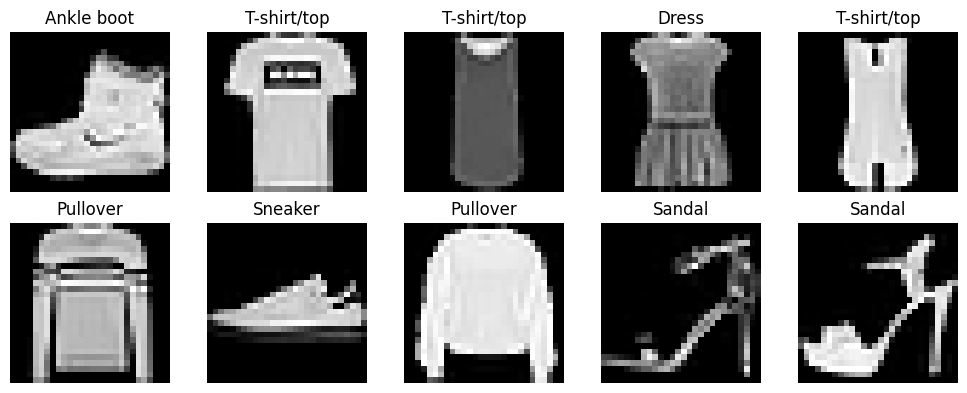

In [2]:
# Load and preprocess Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape to flatten the images
# x_train = x_train.reshape(x_train.shape[0], 28 * 28)
# x_test = x_test.reshape(x_test.shape[0], 28 * 28)

# Add this code after your normalization step
x_train = x_train[..., tf.newaxis]  # New shape: (60000, 28, 28, 1)
x_test = x_test[..., tf.newaxis]    # New shape: (10000, 28, 28, 1)

print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")

# Fashion-MNIST class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Display some sample images
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [3]:
# Sampling layer for the VAE
#TODO: YOUR CODE HERE

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, seed=42, **kwargs):
        super().__init__(**kwargs)
        # Create a stateful random number generator with a fixed seed
        self.generator = tf.random.Generator.from_seed(seed)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        # Sample epsilon from a standard normal distribution
        # NEW WAY (Correct)
        epsilon = tf.random.normal(shape=(batch, dim))
        # epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        # Use the reparameterization trick to sample from the learned distribution
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [4]:
# Build the encoder
latent_dim = 2  # 2D latent space for easy visualization
original_dim = 28 * 28
#TODO: YOUR CODE HEREzx

# x_train = x_train.reshape(28, 28)
# x_test = x_test.reshape(28, 28)

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()



Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 64)           640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 128)            73856     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 4, 4, 256)            295168    ['conv2d_1[0][0]']            
                                                                                            

2025-09-18 18:06:12.394765: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-09-18 18:06:12.394783: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-09-18 18:06:12.394789: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-09-18 18:06:12.394810: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-18 18:06:12.394821: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
# Build the decoder

# Create the decoder model
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 256, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 256))(x)
x = layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
# Print the summary of the decoder
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 12544)             37632     
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 256)       590080    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 128)       295040    
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 1)         1153

In [6]:
# Build the VAE model
#TODO: YOUR CODE HERE

class VAE(keras.Model):
    # Initialize the Variational Autoencoder (VAE)
    def __init__(self, encoder, decoder, beta=0.5, **kwargs):
        super().__init__(**kwargs)
        # Encoder: compresses input data into a latent space
        self.encoder = encoder
        # Decoder: reconstructs input data from the latent space
        self.decoder = decoder
        # Beta: scaling factor for the KL divergence term
        self.beta = beta
        # Metrics to track the total loss during training
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        # Metrics to track the reconstruction loss during training
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        # Metrics to track the KL divergence loss during training
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    # Custom property to return compiled metrics at the end of model training
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    # Custom training step for the model, called on each batch of data
    def train_step(self, data):
        # GradientTape to record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # Encode the input data and retrieve the mean, log variance, and sampled latent vector
            z_mean, z_log_var, z = self.encoder(data)
            # Decode the sampled latent vector to reconstruct the input data
            reconstruction = self.decoder(z)
            # Calculate the mean squared reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            # Calculate the KL divergence loss, scaled by beta
            kl_loss = -0.5 * self.beta * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
            )
            # Total loss is the sum of reconstruction loss and KL divergence loss
            total_loss = reconstruction_loss + kl_loss
        # Compute gradients of the total loss with respect to the weights
        grads = tape.gradient(total_loss, self.trainable_weights)
        # Apply gradients to variables to minimize the total loss
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # Update state of the loss trackers
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        # Return the current loss metrics to monitor during training
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [7]:
# Train the VAE
#TODO: YOUR CODE HERE

vae = VAE(encoder, decoder)
# vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005))
vae.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0005))
history = vae.fit(x_train, epochs=50, batch_size=128)

Epoch 1/50


2025-09-18 18:06:12.983721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 37s 78ms/step - loss: 360.2129 - reconstruction_loss: 305.0832 - kl_loss: 4.1693
Epoch 2/50
469/469 [==============================] - 36s 78ms/step - loss: 276.2176 - reconstruction_loss: 271.2888 - kl_loss: 4.7017
Epoch 3/50
469/469 [==============================] - 38s 81ms/step - loss: 274.9782 - reconstruction_loss: 270.8715 - kl_loss: 5.3992
Epoch 4/50
469/469 [==============================] - 40s 84ms/step - loss: 277.0025 - reconstruction_loss: 271.8329 - kl_loss: 6.0303
Epoch 5/50
469/469 [==============================] - 41s 86ms/step - loss: 281.6985 - reconstruction_loss: 276.8235 - kl_loss: 7.8389
Epoch 6/50
469/469 [==============================] - 44s 95ms/step - loss: 282.1067 - reconstruction_loss: 275.3927 - kl_loss: 8.6411
Epoch 7/50
469/469 [==============================] - 48s 102ms/step - loss: 289.4606 - reconstruction_loss: 277.5838 - kl_loss: 15.2578
Epoch 8/50
469/469 [==============================] - 48s 103ms/

In [20]:
# vae.save('vae_model.h5')
vae.save("vae_model", save_format="tf")

ValueError: Model <__main__.VAE object at 0x332b7a550> cannot be saved either because the input shape is not available or because the forward pass of the model is not defined.To define a forward pass, please override `Model.call()`. To specify an input shape, either call `build(input_shape)` directly, or call the model on actual data using `Model()`, `Model.fit()`, or `Model.predict()`. If you have a custom training step, please make sure to invoke the forward pass in train step through `Model.__call__`, i.e. `model(inputs)`, as opposed to `model.call()`.

dict_keys(['loss', 'reconstruction_loss', 'kl_loss'])


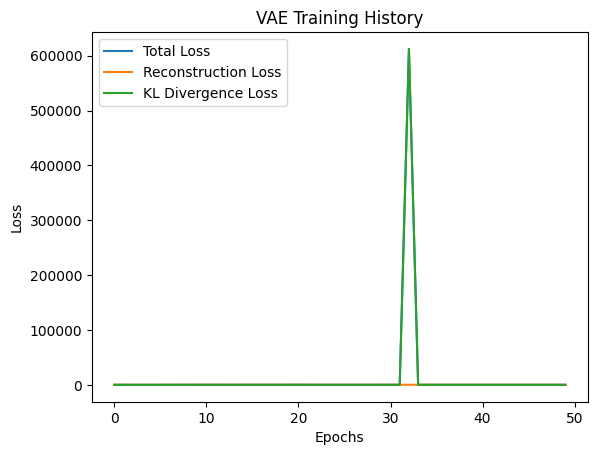

In [8]:
# Plot training history
#TODO: YOUR CODE HERE

import matplotlib.pyplot as plt

# Show what keys are available
print(history.history.keys())

# Plot
plt.plot(history.history["loss"], label="Total Loss")
plt.plot(history.history["reconstruction_loss"], label="Reconstruction Loss")
plt.plot(history.history["kl_loss"], label="KL Divergence Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("VAE Training History")
plt.legend()
plt.show()


2025-09-18 19:09:34.463505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step


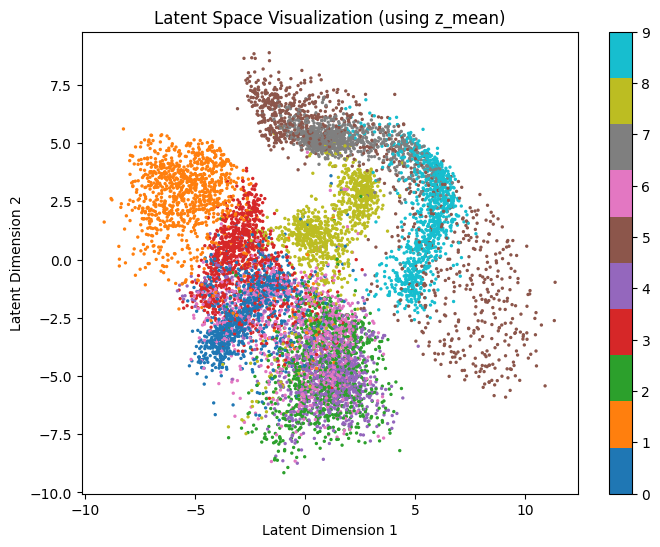

In [9]:
# Visualize the latent space
#TODO: YOUR CODE HERE

# Encode test data into latent space
z_mean, z_log_var, z = encoder.predict(x_test)

# Use z_mean for stable visualization
plt.figure(figsize=(8, 6))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap="tab10", s=2)
plt.colorbar()
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space Visualization (using z_mean)")
plt.show()


2025-09-18 19:09:35.868080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


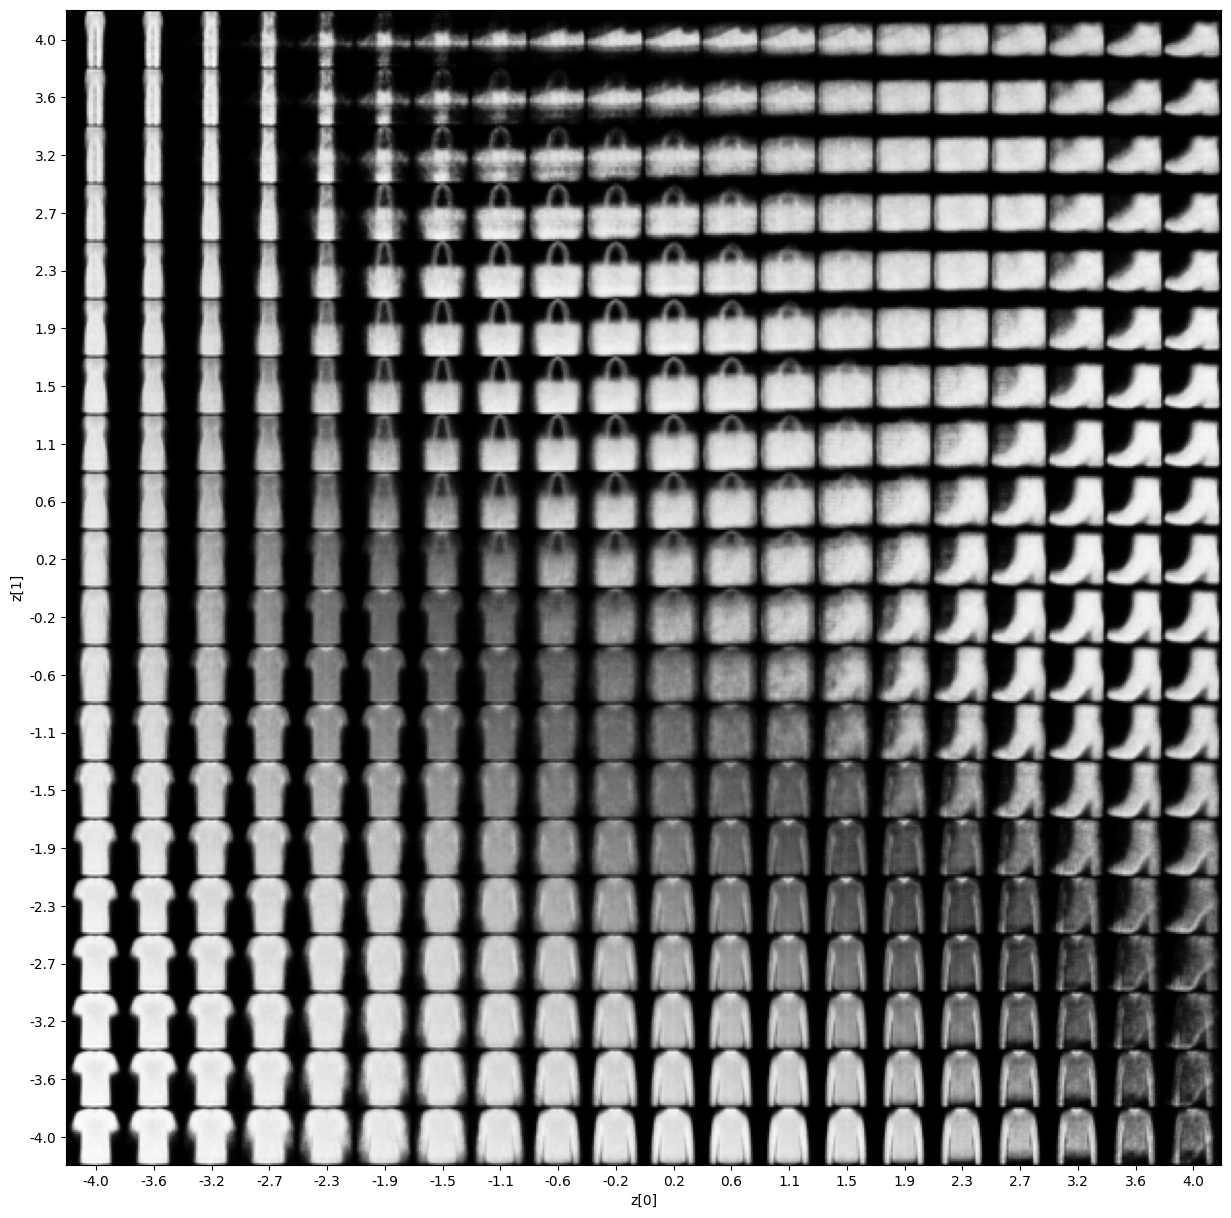

In [10]:
# Visualize the latent space
#TODO: YOUR CODE HERE

import matplotlib.pyplot as plt


def plot_latent_space(vae, n=20, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 4.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

1/1 [==============================] - 0s 99ms/step


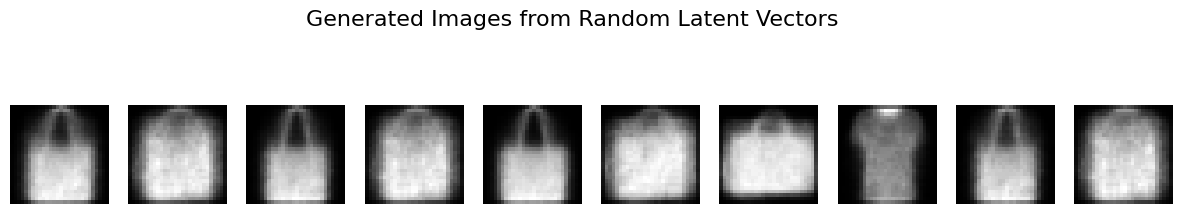

In [11]:
#####################################################
# Generate new images by sampling from latent space #
#####################################################

### YOUR CODE HERE

import numpy as np
import matplotlib.pyplot as plt

# Step 1: sample random points from the latent space
n = 10  # how many images you want to generate
latent_dim = decoder.input_shape[1]  # size of latent space
random_latent_vectors = np.random.normal(size=(n, latent_dim))

# Step 2: use the decoder to generate new images
generated_images = decoder.predict(random_latent_vectors)

# Step 3: plot the generated images
plt.figure(figsize=(15, 3))
for i in range(n):
    plt.subplot(1, n, i + 1)
    plt.imshow(generated_images[i].squeeze(), cmap="gray")
    plt.axis("off")
plt.suptitle("Generated Images from Random Latent Vectors", fontsize=16)
plt.show()


1/1 [==============================] - 0s 10ms/step


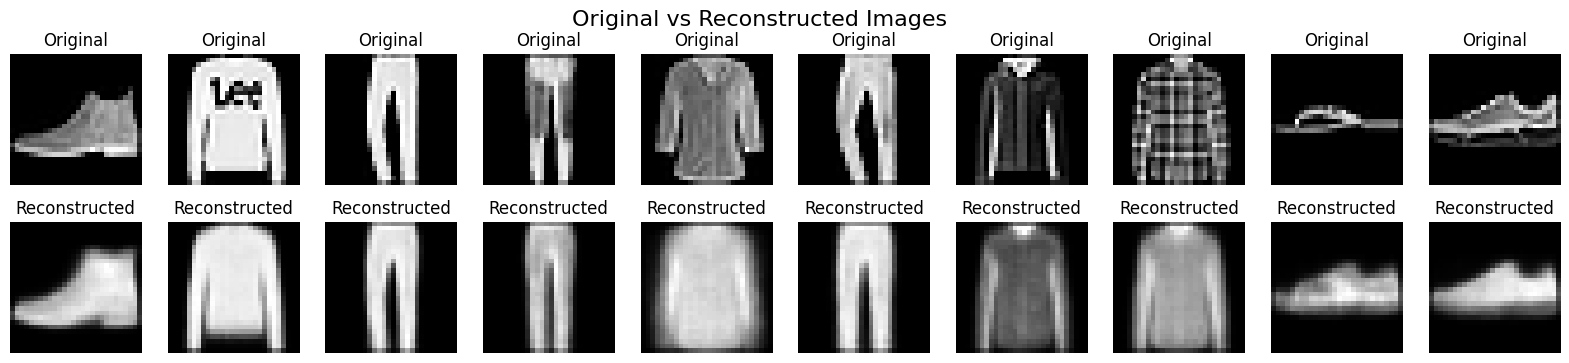

In [12]:
#############################################
# Compare original vs reconstructed images  #
#############################################


### YOUR CODE HERE

import matplotlib.pyplot as plt

# Step 1: Take some test images
n = 10  # number of images to show
test_images = x_test[:n]

# Step 2: Reconstruct them using the VAE
z_mean, z_log_var, z = encoder.predict(test_images)
reconstructed_images = decoder.predict(z)

# Step 3: Plot original vs reconstructed
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].squeeze(), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Reconstructed image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].squeeze(), cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")

plt.suptitle("Original vs Reconstructed Images", fontsize=16)
plt.show()